In [1]:
import numpy as np
from numpy import pi as pi  # Importing the mathematical constant π
import scipy as sc  # Importing SciPy for advanced math operations (not used in the code)
import matplotlib.pyplot as plt  # For visualizing quantum circuits

# Importing Qiskit modules for quantum circuit design and visualization
import qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.result import marginal_counts
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import qiskit.quantum_info as qi

# Updated import to use IBM Runtime primitives
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

import time  # To measure execution time of code

In [ ]:
# IBM Quantum channel; set to default 
QiskitRuntimeService.save_account(channel="ibm_quantum", token=".....", overwrite=True, set_as_default=True)

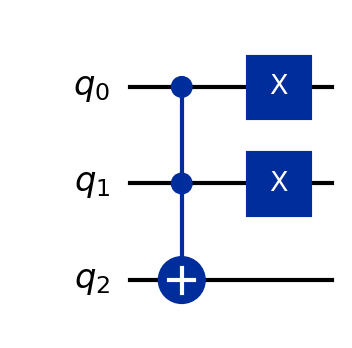

In [3]:
# Defining a function to create quantum circuits dynamically based on inputs
def create_circuit(name, num_qubits, operations):
    """
    Creates a quantum circuit with the specified name, number of qubits, and operations.

    Parameters:
    - name (str): Name of the quantum circuit.
    - num_qubits (int): Number of qubits in the circuit.
    - operations (list of tuples): List of operations to apply. Each operation is defined as:
      (operation_name, *qubit_indices)

    Returns:
    - QuantumCircuit: The constructed quantum circuit.
    """
    circuit = QuantumCircuit(num_qubits, name=name)  # Initialize the quantum circuit
    for op in operations:
        # Dynamically apply each operation to the circuit using getattr
        getattr(circuit, op[0])(*op[1:])
    return circuit

# Defining a dictionary to hold quantum circuit data
# Each entry consists of a circuit name, number of qubits, and a list of operations
circuits_data = {
    "P0+": (3, [("id", 0), ("id", 1), ("id", 2)]),
    "P0-": (3, [("cx", 2, 1), ("x", 0), ("x", 1), ("x", 2), ("ccx", 2, 1, 0), ("x", 1), ("x", 2)]),
    "P1+": (3, [("ccx", 2, 1, 0), ("cx", 2, 1), ("x", 2)]),
    "P1-": (3, [("cx", 1, 0), ("x", 2)]),
    "P2+": (3, [("cx", 1, 0), ("x", 1)]),
    "P2-": (3, [("ccx", 2, 1, 0), ("cx", 2, 1), ("x", 1)]),
    "P3+": (3, [("cx", 2, 1), ("x", 0), ("x", 1), ("x", 2), ("ccx", 2, 1, 0)]),
    "P3-": (3, [("x", 1)]),
    "P4+": (3, [("x", 2)]),
    "P4-": (3, [("cx", 2, 1), ("x", 0), ("x", 1), ("x", 2), ("ccx", 2, 1, 0), ("x", 2), ("x", 1)]),
    "P5+": (3, [("ccx", 2, 1, 0), ("cx", 2, 1), ("x", 0), ("x", 2)]),
    "P5-": (3, [("x", 1), ("x", 2), ("cx", 1, 0), ("x", 1)]),
    "P6+": (3, [("x", 1), ("cx", 1, 0)]),
    "P6-": (3, [("ccx", 0, 1, 2), ("x", 1), ("x", 0)]),
    "P7+": (3, [("cx", 2, 1), ("x", 2), ("x", 1), ("ccx", 2, 1, 0)]),
    "P7-": (3, [("x", 2), ("x", 1), ("x", 0)]),
}

# Creating quantum circuits for each entry in circuits_data and storing them in a dictionary
circuits = {name: create_circuit(name, data[0], data[1]) for name, data in circuits_data.items()}

# Visualizing the quantum circuit for "P6-" using Matplotlib
circuits["P6-"].draw('mpl', scale=1.5)

In [4]:
# Define a function for building a custom circuit
def QC(qrg, crg, aux_circuit):
    """
    Constructs a custom quantum circuit with the provided auxiliary circuit.

    Parameters:
    - qrg (QuantumRegister): Quantum register with the required number of qubits.
    - crg (ClassicalRegister): Classical register for storing measurement outcomes.
    - aux_circuit (QuantumCircuit): An auxiliary quantum circuit to be appended.

    Returns:
    - QuantumCircuit: The constructed quantum circuit.
    """
    q = QuantumCircuit(qrg, crg)

    # Apply various quantum gates to the qubits
    q.h(0)
    q.h(1)
    q.h(2)
    q.s(1)
    q.z(0)
    q.p(np.pi / 2, 2)
    q.append(aux_circuit, range(3))  # Append the auxiliary circuit
    q.p(np.pi / 2, 1)
    q.h(1)
    q.measure(qrg[1], crg[0])  # Measure qubit 1 and store it in the classical register

    return q

# Define quantum and classical registers
num_qubits = 3
qrg = QuantumRegister(num_qubits, name="q")
crg = ClassicalRegister(1, name="cr")

aux_circuits = []  # List to store aux_circuit values
qcs = []  # List to store qc objects

# Iterate over every key in the dictionary
for key in circuits_data.keys():
    # Retrieve aux_circuit from circuits using the key
    aux_circuit = circuits[key]
    aux_circuits.append(aux_circuit)  # Append to aux_circuits list

    # Create a QC object and append to qcs list
    qc = QC(qrg, crg, aux_circuit)
    qcs.append(qc)

for qc in qcs:
    qc.draw('mpl')

In [5]:
qc.depth()

6

In [6]:
# Transpile to instruction set architecture (ISA) for target GPU
# NOTE: Sampler V2 does not support optimization_level (https://docs.quantum.ibm.com/migration-guides/v2-primitives)
# We'll leave optimization_level in just to be safe
service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuits = pm.run(qcs)

for circuit in isa_circuits:
    print(f">>> Circuit ops (ISA): {circuit.count_ops()}")
    print('depth:', circuit.depth())
    print('gates:', sum(circuit.count_ops().values()))

>>> Circuit ops (ISA): OrderedDict({'rz': 4, 'sx': 2, 'x': 1, 'measure': 1})
depth: 3
gates: 8
>>> Circuit ops (ISA): OrderedDict({'rz': 48, 'sx': 32, 'ecr': 11, 'x': 1, 'measure': 1})
depth: 55
gates: 93
>>> Circuit ops (ISA): OrderedDict({'rz': 36, 'sx': 19, 'ecr': 8, 'x': 3, 'measure': 1})
depth: 46
gates: 67
>>> Circuit ops (ISA): OrderedDict({'sx': 3, 'rz': 3, 'x': 1, 'ecr': 1, 'measure': 1})
depth: 5
gates: 9
>>> Circuit ops (ISA): OrderedDict({'rz': 5, 'sx': 3, 'ecr': 1, 'measure': 1})
depth: 4
gates: 10
>>> Circuit ops (ISA): OrderedDict({'rz': 36, 'sx': 19, 'ecr': 8, 'x': 4, 'measure': 1})
depth: 46
gates: 68
>>> Circuit ops (ISA): OrderedDict({'rz': 49, 'sx': 32, 'ecr': 11, 'x': 2, 'measure': 1})
depth: 56
gates: 95
>>> Circuit ops (ISA): OrderedDict({'rz': 5, 'sx': 2, 'measure': 1})
depth: 3
gates: 8
>>> Circuit ops (ISA): OrderedDict({'rz': 3, 'sx': 2, 'x': 1, 'measure': 1})
depth: 3
gates: 7
>>> Circuit ops (ISA): OrderedDict({'rz': 48, 'sx': 32, 'ecr': 11, 'x': 1, 'measur

In [9]:
from qiskit.quantum_info import hellinger_fidelity

# Initialize the sampler with your backend
sampler = Sampler(backend)

# Initialize lists to store results for each circuit
fidelities = []

# Loop through each circuit in isa_circuits
for circuit in isa_circuits:
    # Submit the circuit to the sampler twice
    res1 = sampler.run([circuit]).result()
    res2 = sampler.run([circuit]).result()
    
    # Access counts from the result for the classical register 'cr'
    counts1 = res1[0].data['cr'].get_counts()
    counts2 = res2[0].data['cr'].get_counts()
    
    # Compute Hellinger fidelity between the two result sets
    fidelity = hellinger_fidelity(counts1, counts2)
    fidelities.append(fidelity)

# Print the fidelities for each circuit
for idx, fidelity in enumerate(fidelities):
    print(f"Fidelity for circuit {idx}: {fidelity}")

C:\Users\Evan\anaconda3\envs\superstaq\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:836: UserWarning: The backend ibm_sherbrooke currently has a status of internal.
  warnings.warn(


Fidelity for circuit 0: 0.9995912438095313
Fidelity for circuit 1: 0.9996268672018503
Fidelity for circuit 2: 0.9998512382827842
Fidelity for circuit 3: 0.99995777052043
Fidelity for circuit 4: 1.0
Fidelity for circuit 5: 0.9997145945049833
Fidelity for circuit 6: 0.9999867882448096
Fidelity for circuit 7: 0.9999935558658415
Fidelity for circuit 8: 0.9999888370654938
Fidelity for circuit 9: 0.9998033448065612
Fidelity for circuit 10: 0.9994469369006603
Fidelity for circuit 11: 0.9994835072247339
Fidelity for circuit 12: 1.0
Fidelity for circuit 13: 0.9999349647307626
Fidelity for circuit 14: 0.9984544730105515
Fidelity for circuit 15: 0.9998134111351089
